# Track on Radar data, Segment on satellite data


This notebooks shows:
- how to input NEXRAD radar data and GOES satellite data from Amazon cloud service and prepare it for use in tobac
- how to identify features on one data type (3D radar data) and to connect another data type (satellite data) to these features via segmentation


This is an idealized show case that ignores potential data mismatches, in our case the mismatch due to parallax effects.


## Library Imports

*Note: In addition to the normal *tobac* requirements, this tutorial also requires that Py-ART and s3fs are installed.*


In [1]:
# Import libraries:
import pyart
import xarray as xr
import s3fs
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.pyplot import cm as cmaps
import pandas as pd
from pathlib import Path
import iris
from pyproj import Proj, Geod

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Disable a few warnings:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, append=True)
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", category=FutureWarning, append=True)
warnings.filterwarnings("ignore", category=pd.io.pytables.PerformanceWarning)

In [3]:
# Import tobac itself:
import tobac
import tobac.utils

print("using tobac version", str(tobac.__version__))

using tobac version 1.5.5


## Data Input and Preparations

### Reading radar data and satellite data from Amazon S3

In [4]:
# read in radar data
radar = pyart.io.read_nexrad_archive(
    "s3://noaa-nexrad-level2/2021/05/26/KGLD/KGLD20210526_155623_V06"
)

In [5]:
# read in satellite data
fs = s3fs.S3FileSystem(anon=True)
aws_url = "s3://noaa-goes16/ABI-L2-MCMIPC/2021/146/15/OR_ABI-L2-MCMIPC-M6_G16_s20211461556154_e20211461558539_c20211461559030.nc"

goes_data = xr.open_dataset(fs.open(aws_url), engine="h5netcdf")

In [6]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

### Preparing GOES satellite data

In the next steps, we
- calculate longitude and latitude values using geostationary satellite projection
- construct a GOES dataset with lon/lat as coordinates
- finally, convert the dataset into an Iris Cube (which is taken as tobac input)

In [7]:
"""
Because the GOES data comes in without latitude/longitude values, we need to calculate those. 
"""


def lat_lon_reproj(g16nc):
    # GOES-R projection info and retrieving relevant constants
    proj_info = g16nc["goes_imager_projection"]
    lon_origin = proj_info.attrs["longitude_of_projection_origin"]
    H = proj_info.attrs["perspective_point_height"] + proj_info.attrs["semi_major_axis"]
    r_eq = proj_info.attrs["semi_major_axis"]
    r_pol = proj_info.attrs["semi_minor_axis"]

    # grid info
    lat_rad_1d = g16nc.variables["x"][:]
    lon_rad_1d = g16nc.variables["y"][:]

    # create meshgrid filled with radian angles
    lat_rad, lon_rad = np.meshgrid(lat_rad_1d, lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin * np.pi) / 180.0

    a_var = np.power(np.sin(lat_rad), 2.0) + (
        np.power(np.cos(lat_rad), 2.0)
        * (
            np.power(np.cos(lon_rad), 2.0)
            + (((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(lon_rad), 2.0))
        )
    )
    b_var = -2.0 * H * np.cos(lat_rad) * np.cos(lon_rad)
    c_var = (H**2.0) - (r_eq**2.0)

    r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)

    s_x = r_s * np.cos(lat_rad) * np.cos(lon_rad)
    s_y = -r_s * np.sin(lat_rad)
    s_z = r_s * np.cos(lat_rad) * np.sin(lon_rad)

    lat = (180.0 / np.pi) * (
        np.arctan(
            ((r_eq * r_eq) / (r_pol * r_pol))
            * ((s_z / np.sqrt(((H - s_x) * (H - s_x)) + (s_y * s_y))))
        )
    )
    lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return lon, lat

In [8]:
llons, llats = lat_lon_reproj(goes_data)

full_goes_data = goes_data["CMI_C14"].values
in_goes_for_tobac = xr.Dataset(
    data_vars={
        "C14_brightness_temperature": (
            ("time", "Y", "X"),
            [full_goes_data],
        )
    },
    coords={
        "time": [goes_data["time_bounds"][0].values],
        "longitude": (["Y", "X"], llons),
        "latitude": (["Y", "X"], llats),
    },
)

In [9]:
def enhanced_colormap(vmin=200.0, vmed=240.0, vmax=300.0):
    '''
    Creates enhanced colormap typical of IR BTs.
    '''
    nfull = 256

    ngray = int(nfull * (vmax - vmed) / (vmax - vmin))
    ncol = nfull - ngray

    colors1 = plt.cm.gray_r(np.linspace(0.0, 1.0, ngray))
    colors2 = plt.cm.Spectral(np.linspace(0., 0.95, ncol))

    # combine them and build a new colormap
    colors = np.vstack((colors2, colors1))
    mymap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
        "enhanced_colormap", colors
    )

    return mymap

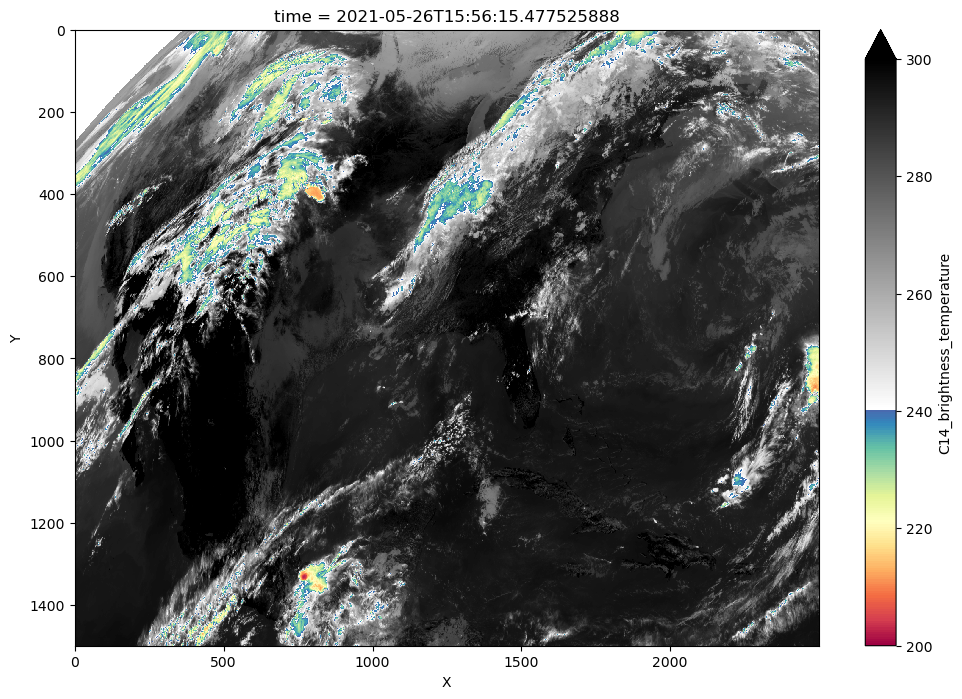

In [10]:
in_goes_for_tobac["C14_brightness_temperature"].plot(
    yincrease=False, vmin=200, vmax=300.0, cmap=enhanced_colormap(), figsize=(12, 8)
)

In [11]:
goes_array_iris = in_goes_for_tobac["C14_brightness_temperature"].to_iris()

### Preparing Radar Data

In the next steps, we
- map radar data onto a regular grid
- construct a 3D radar dataset and add longitude, latitude and altitude as coordinates
- finally, convert the dataset into an Iris Cube (which is taken as tobac input)

In [12]:
# First, we need to grid the input radar data.
radar_grid_pyart = pyart.map.grid_from_radars(
    radar,
    grid_shape=(41, 401, 401),
    grid_limits=(
        (
            0.0,
            20000,
        ),
        (-200000.0, 200000.0),
        (-200000, 200000.0),
    ),
)

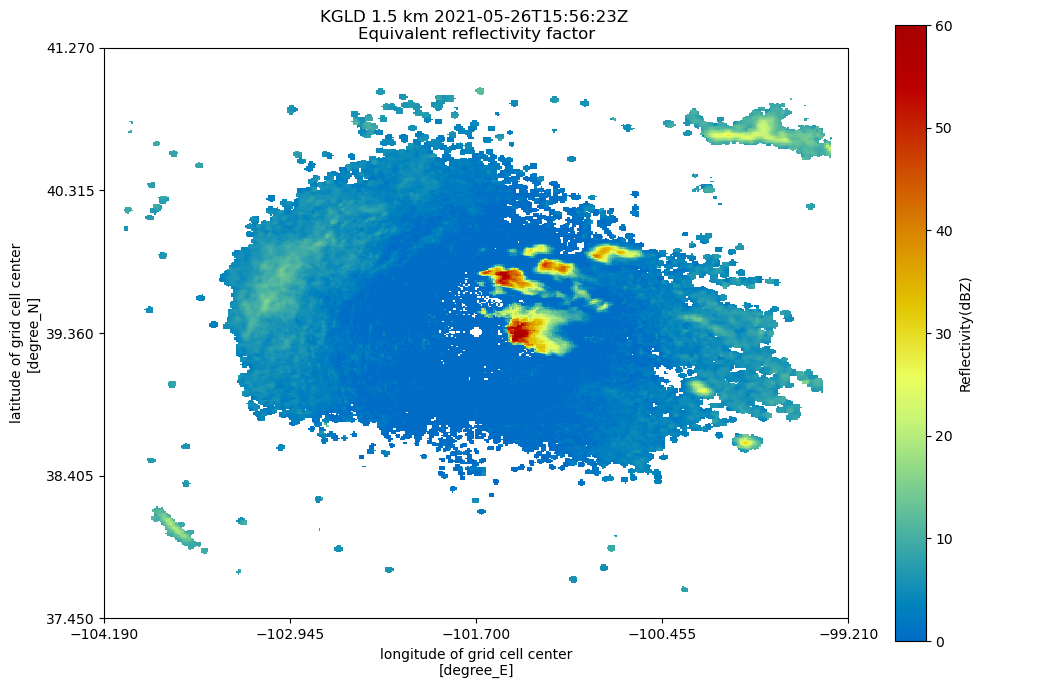

In [13]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[12, 8])
plt.axis("off")

display = pyart.graph.GridMapDisplay(radar_grid_pyart)
display.plot_grid("reflectivity", level=3, vmin=0, vmax=60, fig=fig)

In [14]:
radar_xarray_grid = radar_grid_pyart.to_xarray()

In [15]:
radar_xr_grid_full = radar_xarray_grid["reflectivity"][:, 4]
radar_xr_grid_full["z"] = radar_xr_grid_full.z.assign_attrs(
    {"standard_name": "altitude"}
)
radar_xr_grid_full["lat"] = radar_xr_grid_full.lat.assign_attrs(
    {"standard_name": "latitude"}
)
radar_xr_grid_full["lon"] = radar_xr_grid_full.lon.assign_attrs(
    {"standard_name": "longitude"}
)

In [16]:
radar_xr_grid_full = radar_xr_grid_full.drop_vars(['origin_altitude', 'origin_longitude', 'origin_latitude'], errors='ignore')

In [17]:
radar_grid_iris = radar_xr_grid_full.to_iris()

In [18]:
radar_xr_grid_full

<xarray.DataArray 'reflectivity' (time: 1, y: 401, x: 401)> Size: 643kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                        (time) object 8B 2021-05-26 15:56:23.106000
    z                           float64 8B 2e+03
    lat                         (y, x) float64 1MB 37.55 37.55 ... 41.14 41.14
    lon                         (y, x) float64 1MB -104.0 -104.0 ... -99.31
  * y                           (y) float64 3kB -2e+05 -1.99e+05 ... 2e+05
  * x                           (x) float64 3kB -2e+05 -1.99e+05 ... 2e+05
    ProjectionCoordinateSystem  int32 4B 1
    projection                  int32 4B 1
Attributes:
    units:          dBZ
    standard_name:  equivalent_reflectivity_factor
    long_name:      Reflectivity
    valid_max:      94.5
    valid_min:      -32.0
    coordinates:    elevation azimuth range
    _FillValue:     -9999.0

### Combined Plot

In [19]:
# first we cut satellite data a little bit
rlon_min, rlon_max = radar_xarray_grid.lon.min().data, radar_xarray_grid.lon.max().data
rlat_min, rlat_max = radar_xarray_grid.lat.min().data, radar_xarray_grid.lat.max().data

lon_mask = (llons >= rlon_min) & (llons <= rlon_max)
lat_mask = (llats >= rlat_min) & (llats <= rlat_max)
mask = lon_mask & lat_mask


goes_cutted = (
    in_goes_for_tobac.where(mask).dropna("X", how="all").dropna("Y", how="all")
)

In [20]:
Zmax = radar_xarray_grid['reflectivity'].max('z').squeeze()

(37.54600438517133, 41.16558741816462)

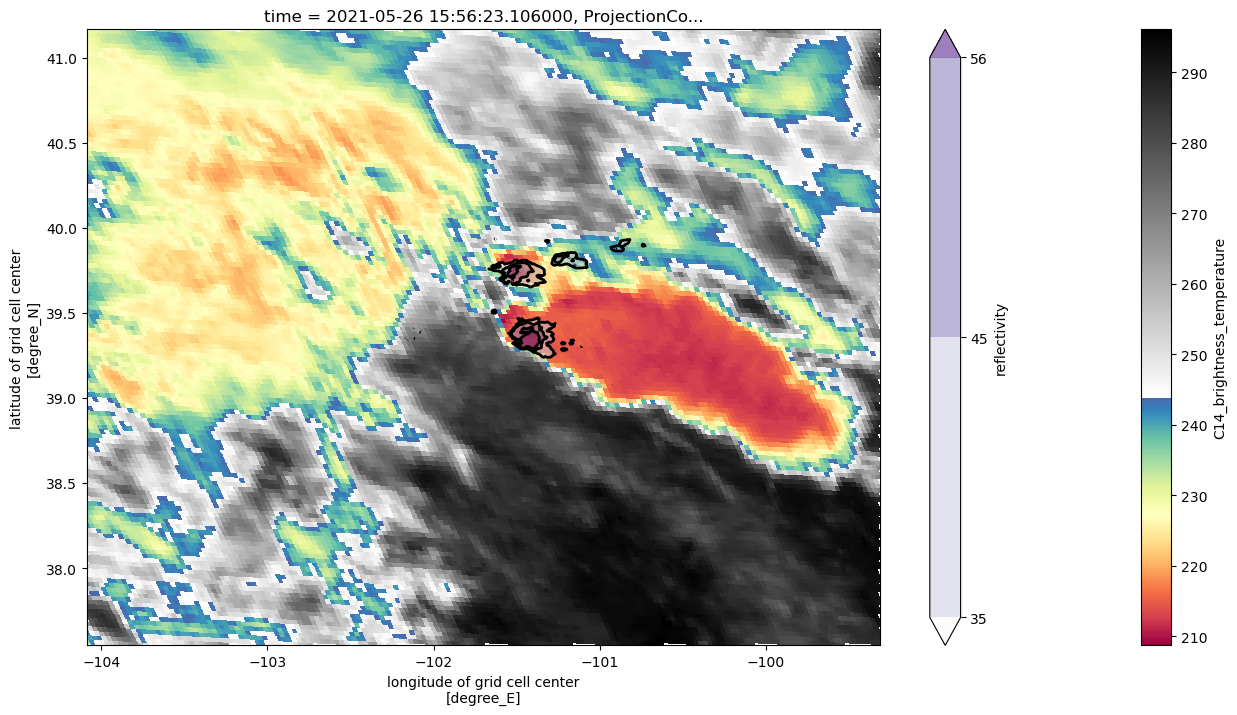

In [21]:
goes_cutted["C14_brightness_temperature"].plot(
    x="longitude", y="latitude", cmap=enhanced_colormap(), figsize=(16, 8)
)

Zmax.where(Zmax > 34).plot.contourf(
    x="lon",
    y="lat",
    cmap=plt.cm.Purples,
    levels=[35, 45, 56],
    alpha=0.5,
)

Zmax.where(Zmax > 20).plot.contour(
    x="lon", y="lat", colors="k", levels=[35, 45, 56], linewidths=2
)

plt.xlim(rlon_min, rlon_max)
plt.ylim(rlat_min, rlat_max)

## Tobac Cloud Tracking

### Feature detection

We use multiple thresholds to detect features in the radar data.

In [22]:
feature_detection_params = dict()
feature_detection_params["threshold"] = [30, 40, 50]
feature_detection_params["target"] = "maximum"
feature_detection_params["position_threshold"] = "weighted_diff"
feature_detection_params["n_erosion_threshold"] = 2
feature_detection_params["sigma_threshold"] = 1
feature_detection_params["n_min_threshold"] = 4

In [23]:
radar_grid_iris

<iris 'Cube' of equivalent_reflectivity_factor / (dBZ) (time: 1; y: 401; x: 401)>

In [24]:
# Perform feature detection:
print('starting feature detection')
radar_features = tobac.feature_detection.feature_detection_multithreshold(
    radar_grid_iris, 0, **feature_detection_params
)
radar_features.to_hdf(savedir / 'Features.h5', 'table')
print('feature detection performed and saved')

starting feature detection


feature detection performed and saved


In [25]:
radar_features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,y,x,ProjectionCoordinateSystem,altitude,projection,latitude,longitude
0,0,5,259.033795,272.057474,21,30,1,2021-05-26 15:56:23,2021-05-26 15:56:23,59033.795289,72057.474012,72057.474012,72057.474012,72057.474012,39.894806,-100.855637
1,0,9,250.679942,241.173074,8,40,2,2021-05-26 15:56:23,2021-05-26 15:56:23,50679.941569,41173.073568,41173.073568,41173.073568,41173.073568,39.821728,-101.218174
2,0,11,198.905962,225.650076,51,50,3,2021-05-26 15:56:23,2021-05-26 15:56:23,-1094.038287,25650.076153,25650.076153,25650.076153,25650.076153,39.356723,-101.401943
3,0,12,243.423204,217.568693,8,50,4,2021-05-26 15:56:23,2021-05-26 15:56:23,43423.204111,17568.692877,17568.692877,17568.692877,17568.692877,39.757277,-101.494756


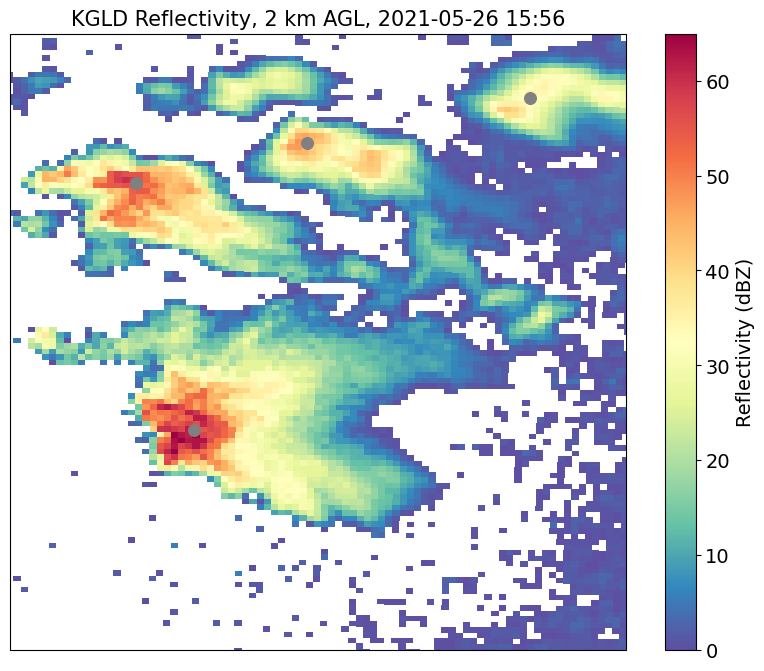

In [26]:
# we now have 4 detected features

fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())


Z = radar_xarray_grid["reflectivity"][0, 4]
cm = ax.pcolormesh(
    radar_xarray_grid["lon"],
    radar_xarray_grid["lat"],
    Z.where(Z> 0),
    vmin=0,
    vmax=65,
    transform=ccrs.PlateCarree(),
    cmap="Spectral_r",
)
plt.xlim(-101.7, -100.7)
plt.ylim(39.0, 40)
cb = plt.colorbar(cm)
cb.set_label("Reflectivity (dBZ)", size=14)
cb.ax.tick_params(labelsize=14)
plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
plt.scatter(
    radar_features["longitude"],
    radar_features["latitude"],
    70,
    transform=ccrs.PlateCarree(),
    color="grey",
)

In [27]:
# maximum space away in m,  maximum time away as Python Datetime object
goes_adj_features = tobac.utils.transform_feature_points(
    radar_features,
    goes_array_iris,
    max_time_away=datetime.timedelta(minutes=1),
    max_space_away=20 * 1000,
)

In [28]:
# the transformed dataframe needs to have identical time to the data to segment on.
# replacement_dt = np.datetime64(in_goes_for_tobac['time'][0].values, 's')
# however, iris cannot deal with times in ms, so we need to drop the ms values.

# goes_adj_features['time'] = replacement_dt

In [29]:
goes_adj_features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,y,x,ProjectionCoordinateSystem,altitude,projection,latitude,longitude
index,,,,,,,,,,,,,,,,
0,0.0,5.0,372.0,806.0,21.0,30.0,1,2021-05-26 15:56:15,2021-05-26 15:56:23,59033.795289,72057.474012,72057.474012,72057.474012,72057.474012,39.894806,-100.855637
1,0.0,9.0,376.0,792.0,8.0,40.0,2,2021-05-26 15:56:15,2021-05-26 15:56:23,50679.941569,41173.073568,41173.073568,41173.073568,41173.073568,39.821728,-101.218174
2,0.0,11.0,393.0,778.0,51.0,50.0,3,2021-05-26 15:56:15,2021-05-26 15:56:23,-1094.038287,25650.076153,25650.076153,25650.076153,25650.076153,39.356723,-101.401943
3,0.0,12.0,379.0,781.0,8.0,50.0,4,2021-05-26 15:56:15,2021-05-26 15:56:23,43423.204111,17568.692877,17568.692877,17568.692877,17568.692877,39.757277,-101.494756


**Segmentation:**  

In [30]:
parameters_segmentation = dict()
parameters_segmentation["method"] = "watershed"
parameters_segmentation["threshold"] = 235
parameters_segmentation["target"] = "minimum"

In [31]:
# Perform segmentation and save results:
print('Starting segmentation.')
seg_data, seg_feats = tobac.segmentation.segmentation(
    goes_adj_features, goes_array_iris, dxy=2000, **parameters_segmentation
)
print('segmentation performed, start saving results to files')
iris.save([seg_data], savedir / 'Mask_Segmentation_sat.nc', zlib=True, complevel=4)     
seg_feats.to_hdf(savedir / 'Features_sat.h5', 'table')
print('segmentation performed and saved')

Starting segmentation.


segmentation performed, start saving results to files
segmentation performed and saved


In [32]:
seg_data_xr = xr.DataArray.from_iris(seg_data)

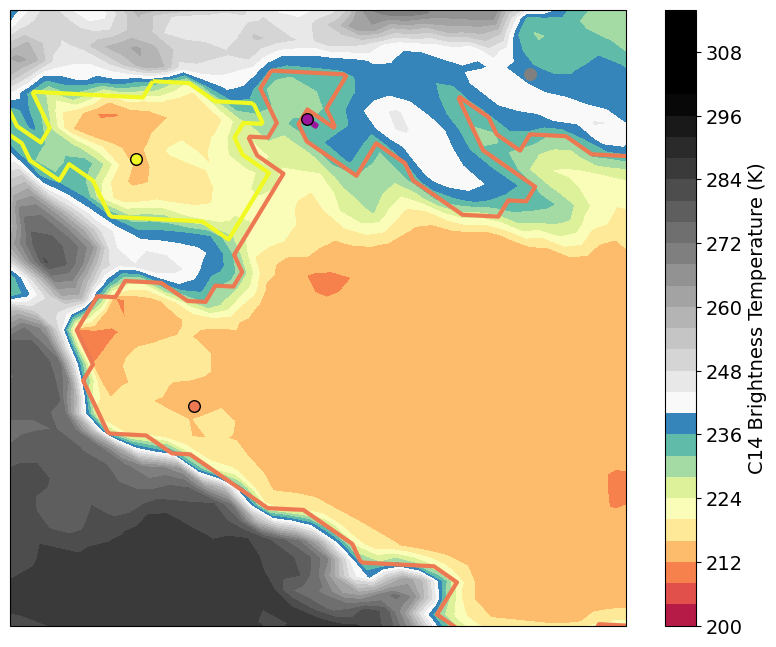

In [33]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

contoured = ax.contourf(
    in_goes_for_tobac["longitude"],
    in_goes_for_tobac["latitude"],
    in_goes_for_tobac["C14_brightness_temperature"][0],
    transform=ccrs.PlateCarree(),
    cmap=enhanced_colormap(), vmin = 200, vmax = 300, levels = 31
)
plt.xlim(-101.7, -100.7)
plt.ylim(39.0, 40)
unique_seg = np.unique(seg_data_xr)
color_map = cmaps.plasma(np.linspace(0, 1, len(unique_seg)))

# we have one feature without a segmented area
curr_feat = goes_adj_features[goes_adj_features["feature"] == 1]
plt.scatter(
    curr_feat["longitude"],
    curr_feat["latitude"],
    70,
    transform=ccrs.PlateCarree(),
    color="grey",
)


for seg_num, color in zip(unique_seg, color_map):
    if seg_num == 0 or seg_num == -1:
        continue
    curr_seg = (seg_data_xr == seg_num).astype(int)
    ax.contour(
        seg_data_xr["longitude"],
        seg_data_xr["latitude"],
        curr_seg,
        colors=[
            color,
        ],
        levels=[
            0.9,1
        ],
        linewidths=3,
    )
    curr_feat = goes_adj_features[goes_adj_features["feature"] == seg_num]
    plt.scatter(
        curr_feat["longitude"],
        curr_feat["latitude"],
        70,
        transform=ccrs.PlateCarree(),
        color=color,
        edgecolors = 'black',
        zorder = 10
    )

cb = plt.colorbar(contoured)
cb.set_label("C14 Brightness Temperature (K)", size=14)
cb.ax.tick_params(labelsize=14)
# plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
# plt.savefig("./radar_example_2/satellite_wseg.png", facecolor='w', bbox_inches='tight')

*result*:
- convective anvils could be connected to two respective radar cells
- ignoring parallax shifts can cause assignment problems for smaller anvils (see purple radar cell)